In [2]:
# ------------------------------mount drive-------------------------------------
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab\ Notebooks/nonlinear-sys-id/quadrotor\ sys\ id/

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/nonlinear-sys-id/quadrotor sys id


# Getting Trajectory Data of Quadrotor

In [3]:
# --------------------------import packages-------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)

from quadrotor_dynamics import system_parameters, euler_to_quaternion, QuadrotorDynamics

# --------------------------ground_truth parameters-----------------------------
I_xx, I_yy, I_zz, Ax, Ay, Az, m, _, _, _, _ = system_parameters()
ground_truth = [1 / m, -Ax / m, -Ay / m, -Az / m,
                (I_yy - I_zz) / I_xx, 1 / I_xx,
                (I_zz - I_xx) / I_yy, 1 / I_yy,
                (I_xx - I_yy) / I_zz, 1 / I_zz]

print("-----------------------------------------------------------------------")
print("ground truth = ", ground_truth)
print("-----------------------------------------------------------------------")

n_epoch = 10              # number trajectories
max_time_hor = 30002      # maximum trajectory length

# ------------------------------disturbacne-------------------------------------
# disturbance: str = "trunc_guass"
# parameter_dist = [0.0, 0.5, 2]  # mean and std

disturbance: str = "uniform"
parameter_dist = [-1, 1]  # lb and ub

seeds_w = range(300, 500) # fixing seeds
w_max = 0.01             # maximum disturbance (required to run set membership)

# ---------------------------------noise----------------------------------------
# c_input: str = "trunc_guass"
# parameter_input = [0.0, 0.5, 2]  # mean and std

c_input: str = "uniform"
parameter_input = [-1, 1]  # lb and ub

mult_u = [1, 0.2, 0.2, 0.2]

seeds_u = range(100, 200)   # fixing seeds

print('------------------Getting Trajectory Data of Quadrotor-----------------')

theta_hat_list = []
Delta_S_list = []
Phi_S_U_list = []

for e in range(n_epoch):

  # q0, q1, q2, q3 = euler_to_quaternion(10 * np.pi/180, 10 * np.pi/180, 10 * np.pi/180)
  q0 = 1
  q1 = 0
  q2 = 0
  q3 = 0
  x0 = [0., 0., 1., 0., 0., 0., q0, q1, q2, q3, 0., 0., 0.]
  qudt = QuadrotorDynamics(c_input, disturbance)
  qudt.get_trajectory_3(x0, max_time_hor, seeds_u[e], seeds_w[e], parameter_input, mult_u, parameter_dist)
  # print("---------------------------------------------------------------------")
  print("e = ", e + 1)
  # qudt.plot_trajectory()

  Delta_S_list.append(qudt.b_s_list)
  Phi_S_U_list.append(qudt.phi_s_u_list)     # nonlinear feature vector

print('-------------------------------Data Saved------------------------------')

-----------------------------------------------------------------------
ground truth =  [2.1367521367521367, -0.5341880341880342, -0.5341880341880342, -0.5341880341880342, -0.8123970345963756, 205.9308072487644, 0.8123970345963756, 205.9308072487644, 0.0, 113.62345188046812]
-----------------------------------------------------------------------
------------------Getting Trajectory Data of Quadrotor-----------------
e =  1
e =  2
e =  3
e =  4
e =  5
e =  6
e =  7
e =  8
e =  9
e =  10
-------------------------------Data Saved------------------------------


# Set Membership Estimation (SME)

# Run SME

In [4]:
# ----------------------import packages-------------------------------------
import numpy as np
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)
from scipy.spatial import ConvexHull
from scipy.spatial import distance_matrix
from set_membership_lin_prog_qdt import run_set_membership

time_hor = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900]
time_hor.extend([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
time_hor.extend([10000, 15000, 20000, 25000, 30000])

# time_hor = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000]

intersection_points = []
mean_diam_list = []
std_diam_list = []
print('-------------------------------Run SME---------------------------------')
for k in range(len(time_hor)):
  print('T = ' + str(time_hor[k]))
  print('-------------------------------------------------------------------')
  intersection_points_ = []
  diam_list = []
  # volume_list = []
  for e in range(n_epoch):
    print('epoch = ' + str(e+1))
    points, _ = run_set_membership(Delta_S_list[e][:time_hor[k]], Phi_S_U_list[e][:time_hor[k]], w_max)
    distances_ = distance_matrix(points, points)
    diam_list.append(np.max(distances_))
    intersection_points_.append(points)
  mean_diam_list.append(np.mean(np.array(diam_list), axis=0))
  # alpha = 0.05  # 95% confidence interval
  # z_score = norm.ppf(1 - alpha / 2)
  # coeff = z_score / np.sqrt(n_epoch)
  coeff = 1
  std_diam_list.append(coeff * np.std(np.array(diam_list), axis=0))
  intersection_points.append(intersection_points_)

print('---------------------------------Done!---------------------------------')

# save array into csv file
name1 = 'sme_data1_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
name2 = 'sme_data2_' + 'w_' + disturbance + '_' + str(parameter_dist) + '_u_' + c_input + '_' + str(parameter_input) + '_' + str(mult_u) + '.csv'
np.savetxt(name1, np.array(mean_diam_list), delimiter = ",")
np.savetxt(name2, np.array(std_diam_list), delimiter = ",")

-------------------------------Run SME---------------------------------
T = 10
-------------------------------------------------------------------
epoch = 1
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.2000e+00  1e+02  6e+00  0e+00  1e+00
 1:  0.0000e+00 -3.8949e-01  7e+00  1e+00  4e-17  3e-03
 2:  0.0000e+00 -5.4625e-03  2e-02  7e-02  8e-17  2e-02
 3:  0.0000e+00 -1.6328e-03  2e-03  5e-03  8e-18  2e-04
 4:  0.0000e+00 -1.2057e-04  1e-04  4e-04  4e-19  1e-05
 5:  0.0000e+00 -1.3183e-06  1e-06  4e-06  2e-20  1e-07
 6:  0.0000e+00 -1.3181e-08  1e-08  4e-08  8e-22  1e-09
Optimal solution found.
epoch = 2
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
Optimal solution found.
epoch = 3
---------------------- finding a feasible point by cvxopt -- T =  10  -----------
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.2000e+00  

# Plot SME results

------------------------SME Uncertainty Set Diameter Plot---------------------


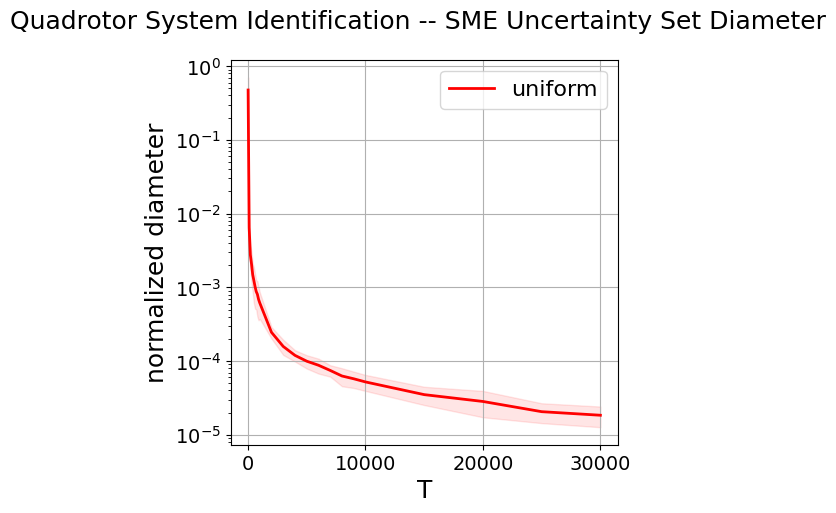

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams['axes.grid'] = True

linewidth_ = 2.0
alpha_ = 0.1
log_scale = True
normalize = True
l_norm = np.inf # 2

def plot_sme_diam(mean_diam, std_diam, time_hor):

  c0 = 1
  if normalize:
    c0 = np.linalg.norm(ground_truth, l_norm)

  time_hor_ = np.array(time_hor)

  if disturbance == 'trunc_guass':
    label_ = 'truncated-Gaussian'
  else:
    label_ = disturbance

  fig = plt.figure(figsize=(5, 5))
  plt.plot(time_hor, np.array(mean_diam) / c0, color='red', label=label_, linewidth=linewidth_)
  plt.fill_between(time_hor, (np.array(mean_diam) - np.array(std_diam)) / c0, (np.array(mean_diam) + np.array(std_diam)) / c0, color='red', alpha=alpha_)
  # plt.xticks([10, 10000, 20000, 30000])
  plt.xlabel('T')
  if normalize:
    plt.ylabel('normalized diameter')
  else:
    plt.ylabel('diameter')
  plt.legend()
  fig.suptitle('Quadrotor System Identification -- SME Uncertainty Set Diameter')
  if log_scale:
    plt.yscale('log')

  plt.show()

print('------------------------SME Uncertainty Set Diameter Plot---------------------')
plot_sme_diam(mean_diam_list, std_diam_list, time_hor)

# Plot Uncertainty Sets

------------------------SME Uncertainty Set Plots----------------------


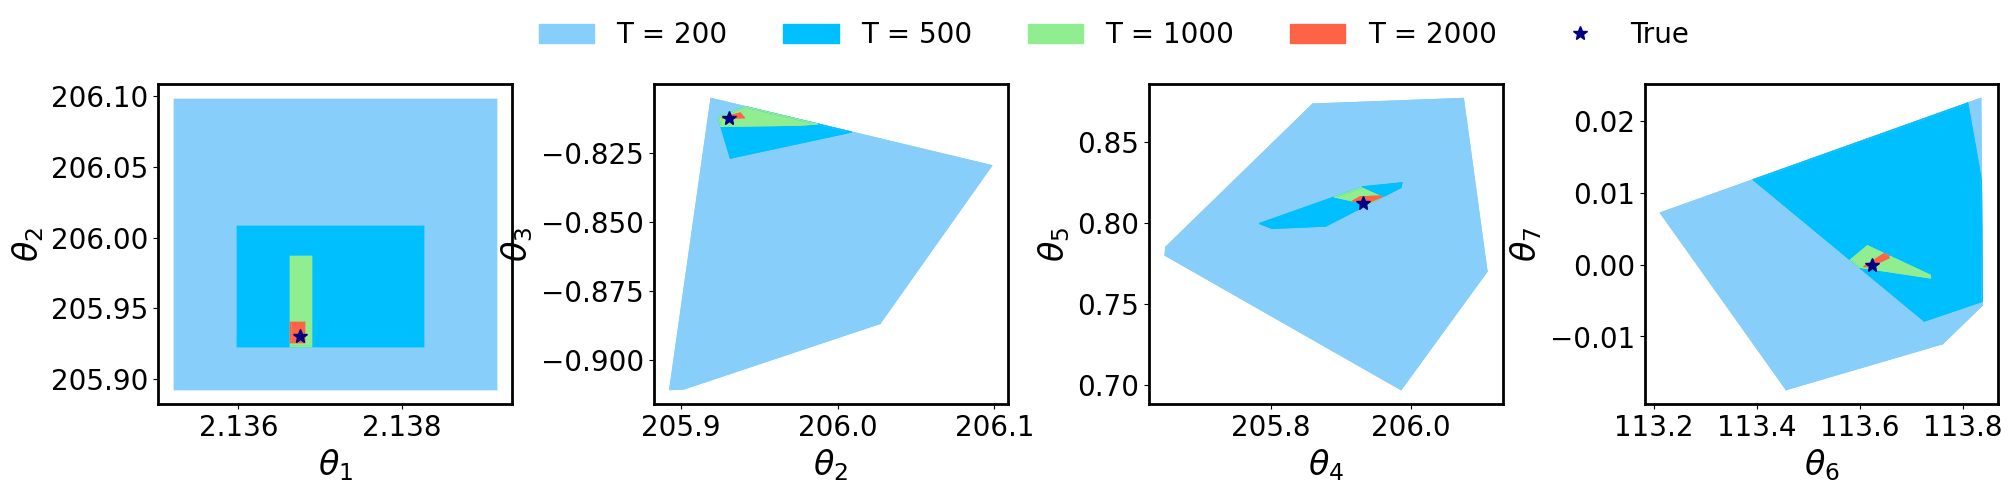

In [6]:
from scipy.spatial import HalfspaceIntersection
from scipy.optimize import linprog
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['axes.grid'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2

linewidth_ = 1
alpha_ = 1

def plot_sm_(inter_points, time_hor, ground_truth, w_max):
    kxs = [0, 5, 7, 9]
    kys = [5, 4, 6, 8]
    ix = [0, 1, 2, 3]

    colors = ['lightskyblue', 'deepskyblue', 'lightgreen', 'tomato']
    lbls = ['T = ', 'T = ', 'T = ', 'T = ', 'T = ', 'T = ', 'T = ', 'T = ']

    fig, axs = plt.subplots(1, 4, figsize=(23, 4))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.2)

    for i in range(len(kxs)):
        for t in range(len(inter_points)):
            n_points = np.zeros((inter_points[t].shape[0], 2))
            n_points[:, 0] = inter_points[t][:, kxs[i]]
            n_points[:, 1] = inter_points[t][:, kys[i]]

            hull = ConvexHull(n_points)
            # axs[ix[i], iy[i]].plot(n_points[:, 0], n_points[:, 1], 'o')

            for simplex in hull.simplices:
                axs[ix[i]].plot(n_points[simplex, 0], n_points[simplex, 1], color=colors[t], linewidth=linewidth_)
            axs[ix[i]].fill(n_points[hull.vertices, 0], n_points[hull.vertices, 1], alpha=alpha_, color=colors[t],
                                   label=lbls[t] + str(time_hor[t]))  # color=colors[t]

            if t == len(inter_points) - 1:
                axs[ix[i]].plot(ground_truth[kxs[i]], ground_truth[kys[i]], '*', markersize=10, markerfacecolor='navy',
                                       markeredgecolor='navy', label='True')

    axs[0].set_xlabel('$\\theta_{1}$')  # ('$\\frac{1}{m}$')
    axs[0].set_ylabel('$\\theta_{2}$') # ('$\\frac{1}{I_{xx}}$')

    axs[1].set_xlabel('$\\theta_{2}$')  # ('$\\frac{1}{I_{xx}}$')
    axs[1].set_ylabel('$\\theta_{3}$')  # ('$\\frac{I_{yy}-I_{zz}}{I_{xx}}$')

    axs[2].set_xlabel('$\\theta_{4}$') #  ('$\\frac{1}{I_{yy}}$')
    axs[2].set_ylabel('$\\theta_{5}$')  # ('$\\frac{I_{zz}-I_{xx}}{I_{yy}}$')

    axs[3].set_xlabel('$\\theta_{6}$')  # ('$\\frac{1}{I_{zz}}$') # ('$\\frac{1}{I_{zz}}$')
    axs[3].set_ylabel('$\\theta_{7}$')   # ('$\\frac{I_{xx}-I_{yy}}{I_{zz}}$')

    axs[0].legend(bbox_to_anchor=(2.7, 1.275), ncol=len(time_hor) + 1, loc='upper center', edgecolor='white')

    plt.show()

print('------------------------SME Uncertainty Set Plots----------------------')
point_list = [intersection_points[2][0], intersection_points[5][0], intersection_points[10][0], intersection_points[11][0]]
time_list = [time_hor[2], time_hor[5], time_hor[10], time_hor[11]]
plot_sm_(point_list, time_list, ground_truth, w_max)
